# Background

### Imbalanced Data Set

### Transaction Table

TransactionDT: timedelta from a given reference datetime (not an actual timestamp)  
TransactionAMT: transaction payment amount in USD  
ProductCD: product code, the product for each transaction  
card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.  
addr: address  
dist: distance  
P_ and (R__) emaildomain: purchaser and recipient email domain  

C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.  

D1-D15: timedelta, such as days between previous transaction, etc.  
M1-M9: match, such as names on card and address, etc.  
Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.  
  
  
Categorical Features:
ProductCD  
card1 - card6  
addr1, addr2  
P_emaildomain  
R_emaildomain  
M1 - M9  

### Identity Table

Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.  

They're collected by Vesta’s fraud protection system and digital security partners.  
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)  

Categorical Features:   
DeviceType  
DeviceInfo    
id_12 - id_38  

# Initialization

In [1]:
%matplotlib inline

import os
from pathlib import Path
import numpy as np
import datetime

import pandas as pd
pd.set_option("display.max_rows",10)

# IPython

from IPython.display import display, Markdown
from IPython.display import Image

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# http://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


# Autoload Python Code
%load_ext autoreload
%autoreload 2

# Identity Data

Information about the data can be found here. 

In [108]:
data_path = Path('/Users/bkraft/data/fraud/raw/')

list(data_path.glob('*.csv'))

[PosixPath('/Users/bkraft/data/fraud/raw/test_transaction.csv'),
 PosixPath('/Users/bkraft/data/fraud/raw/train_identity.csv'),
 PosixPath('/Users/bkraft/data/fraud/raw/test_identity.csv'),
 PosixPath('/Users/bkraft/data/fraud/raw/sample_submission.csv'),
 PosixPath('/Users/bkraft/data/fraud/raw/train_transaction.csv')]

In [80]:
df_train = pd.read_csv(data_path / 'train_transaction.csv')

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 1.7+ GB


In [97]:
def convert_transaction_dt_to_datetime(df, reference_date = '1/1/2018'):
    df['_transaction_timedelta'] = pd.to_timedelta(df['TransactionDT'], unit='seconds')
    df['_transaction_datetime'] = pd.to_datetime(reference_date) + df['_transaction_timedelta']
    
    return df

In [99]:
df_train = convert_transaction_dt_to_datetime(df_train)

In [91]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 396 entries, TransactionID to _transaction_datetime
dtypes: datetime64[ns](1), float64(376), int64(4), object(14), timedelta64[ns](1)
memory usage: 1.7+ GB


In [92]:
df_test = pd.read_csv(data_path / 'test_transaction.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 393 entries, TransactionID to V339
dtypes: float64(376), int64(3), object(14)
memory usage: 1.5+ GB


In [100]:
df_test = convert_transaction_dt_to_datetime(df_test)

# Sample Submission

For each TransactionID in the test set, you must predict a probability for the isFraud variable. The file should contain a header and have the following format:

In [111]:
df_sample = pd.read_csv(data_path / 'sample_submission.csv')
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionID  506691 non-null  int64  
 1   isFraud        506691 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 7.7 MB


In [113]:
df_sample.isFraud.value_counts()

0.5    506691
Name: isFraud, dtype: int64

# Exploratory Data Analysis

### Imbalanced Data Set

In [166]:
df_train.isFraud.value_counts(normalize=False)
df_train.isFraud.value_counts(normalize=True)

0    569877
1     20663
Name: isFraud, dtype: int64

0    0.96501
1    0.03499
Name: isFraud, dtype: float64

### Counts per day

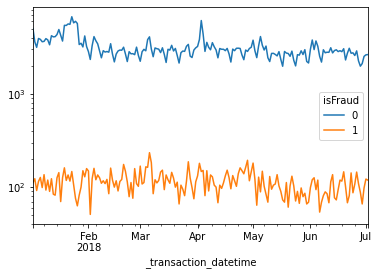

In [101]:
df_count = df_train.groupby([pd.Grouper(key='_transaction_datetime', freq='D'), df_train['isFraud']]).TransactionID.count().unstack()
df_count.plot(logy=True);

In [107]:
df_count = df_train.groupby([df_train['_transaction_datetime'].dt.weekday, df_train['isFraud']]).TransactionID.count().unstack()
df_count#.plot(logy=True, ylim=(1,1000000));

isFraud,0,1
_transaction_datetime,,
0,83166,3211
1,94952,3550
2,76871,2963
3,67720,2503
4,82746,2687
5,82012,2803
6,82410,2946


In [68]:
mask = (df_train.TransactionAmt < 10000) 
mask_fraud = (df_train.isFraud)

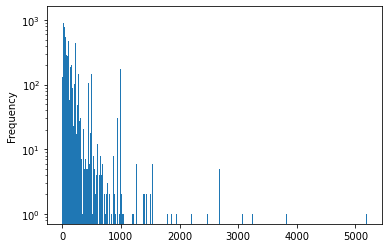

In [71]:
df_train.TransactionAmt[mask & mask_fraud].plot(kind='hist', bins=1000, logy=True);

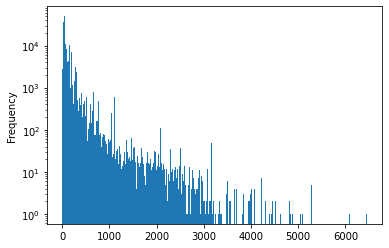

In [72]:
df_train.TransactionAmt[mask & ~mask_fraud].plot(kind='hist', bins=1000, logy=True);

In [66]:
with pd.option_context('display.max_rows', 20):
	df_train[df_train['TransactionAmt'] > 10000]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V331,V332,V333,V334,V335,V336,V337,V338,V339,transaction_time_in_days
274336,3261336,0,6652360,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.994907
274339,3261339,0,6652391,31937.391,W,16075,514.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.995266


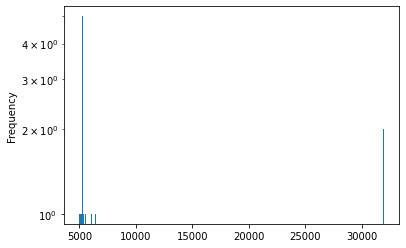

In [60]:
df_train.TransactionAmt[~mask & ~mask_fraud].plot(kind='hist', bins=1000, logy=True);

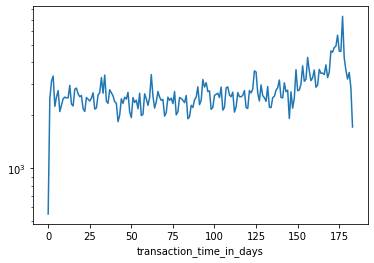

In [40]:
df_test['transaction_time_in_days'] = (df_test.TransactionDT - df_test.TransactionDT.min())/(24*60*60)

df_test['transaction_time_in_days'].describe()

df_count = df_test.groupby([df_test['transaction_time_in_days'].round(0).astype(int)]).TransactionID.count()
df_count.plot(logy=True);

# Missing Values

In [142]:
df_na = (df_train.isna().sum().sort_values().rename('na') / len(df_train)).to_frame()

In [143]:
with pd.option_context('display.max_rows', 400):
	df_na.reset_index()

,index,na
0,TransactionID,0.000000
1,_transaction_timedelta,0.000000
2,C14,0.000000
3,C13,0.000000
4,C12,0.000000
5,C11,0.000000
6,C10,0.000000
7,C9,0.000000
8,C8,0.000000
9,C7,0.000000


### Missing data from Fraud Cases

In [131]:
mask_is_fraud = df_train.isFraud > 0
df_tmp  = df_train[mask_is_fraud]

In [146]:
df_na_fraud_only = (df_tmp.isna().sum().sort_values().rename('na_fraud_only') / len(df_tmp)) .to_frame()

In [149]:
df_tmp = df_na_fraud_only.join(df_na).sort_values(by='na_fraud_only')

In [153]:
with pd.option_context('display.max_rows', 400):
	df_tmp.reset_index()

,index,na_fraud_only,na
0,TransactionID,0.000000,0.000000
1,card1,0.000000,0.000000
2,ProductCD,0.000000,0.000000
3,TransactionAmt,0.000000,0.000000
4,isFraud,0.000000,0.000000
5,_transaction_datetime,0.000000,0.000000
6,C1,0.000000,0.000000
7,C2,0.000000,0.000000
8,C3,0.000000,0.000000
9,C4,0.000000,0.000000


In [159]:
df_tmp2 = df_tmp[df_tmp['na_fraud_only'] < .1]

In [160]:
with pd.option_context('display.max_rows', 200):
	df_tmp2

,na_fraud_only,na
TransactionID,0.000000,0.000000
card1,0.000000,0.000000
ProductCD,0.000000,0.000000
TransactionAmt,0.000000,0.000000
isFraud,0.000000,0.000000
_transaction_datetime,0.000000,0.000000
C1,0.000000,0.000000
C2,0.000000,0.000000
C3,0.000000,0.000000
C4,0.000000,0.000000


In [163]:
df_tmp2.index.tolist()

['TransactionID',
 'card1',
 'ProductCD',
 'TransactionAmt',
 'isFraud',
 '_transaction_datetime',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'TransactionDT',
 'C7',
 'C6',
 '_transaction_timedelta',
 'C13',
 'C12',
 'C14',
 'C10',
 'C9',
 'C8',
 'C11',
 'V310',
 'V304',
 'V309',
 'V308',
 'V306',
 'V305',
 'V307',
 'V295',
 'V299',
 'V298',
 'V297',
 'V294',
 'V303',
 'V292',
 'V302',
 'V293',
 'V279',
 'V291',
 'V312',
 'V287',
 'V286',
 'V284',
 'V280',
 'V316',
 'V285',
 'V318',
 'V319',
 'V320',
 'V321',
 'V311',
 'V290',
 'V317',
 'V117',
 'V135',
 'V96',
 'V133',
 'V132',
 'V131',
 'V130',
 'V129',
 'V128',
 'V119',
 'V125',
 'V124',
 'V123',
 'V122',
 'V121',
 'V120',
 'V136',
 'V127',
 'V137',
 'V126',
 'V118',
 'V95',
 'V116',
 'V114',
 'V134',
 'V107',
 'V113',
 'V112',
 'V111',
 'V109',
 'V108',
 'V106',
 'V110',
 'V104',
 'V98',
 'V115',
 'V97',
 'V99',
 'V105',
 'V101',
 'V102',
 'V103',
 'V100',
 'card6',
 'card3',
 'card4',
 'V282',
 'V283',
 'V296',
 'V301',
 'V300',
 'D1',
 